# Global Disaster Response Efficiency Prediction (RandomForest vs XGBoost)

Dataset link https://www.kaggle.com/datasets/mubeenshehzadi/global-disaster-2018-2024

About dataset:

The Global Disaster Dataset (2018–2024) provides a comprehensive record of natural and environmental disasters that occurred worldwide between 2018 and 2024. It captures key aspects of disaster events — including their type, severity, human impact, economic damage, and response effectiveness. Each record represents a unique disaster event in a specific country, offering detailed information on how efficiently aid and recovery efforts were managed following the incident.
Disasters such as earthquakes, floods, hurricanes, and wildfires cause widespread human and economic damage.  
The effectiveness of response operations—how quickly and efficiently countries react—plays a crucial role in minimizing losses and accelerating recovery.
## Introduction
This notebook uses a global disaster dataset to understand and predict how efficiently different countries respond to disasters.  
By analyzing historical records containing factors such as disaster severity, casualties, economic losses, aid distributed, and response times, we aim to uncover the key drivers of effective response.

## Objective
The goal is to build machine learning models that predict the **Response Efficiency Score** (0–100 scale) for disaster events.  
This score represents how well and how quickly relief and recovery operations were executed after a disaster.

## Approach
1. Perform exploratory data analysis (EDA) to understand relationships among severity, aid, casualties, and efficiency.  
2. Engineer temporal and categorical features such as year, month, country, and disaster type.  
3. Train and compare tree-based models (Random Forest and XGBoost) to predict the Response Efficiency Score.  
4. Evaluate model performance using R², MAE, RMSE, and cross-validation.  
5. Interpret the most important features influencing disaster response efficiency using feature importance and SHAP analysis.

The findings can guide future preparedness, policy decisions, and data-driven disaster management strategies.


## Imports

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')


## Load The Data

In [2]:
# Download latest version
path = kagglehub.dataset_download("mubeenshehzadi/global-disaster-2018-2024")

print("Path to dataset files:", path)

100%|██████████| 1.66M/1.66M [00:00<00:00, 143MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/mubeenshehzadi/global-disaster-2018-2024/versions/1


In [3]:
print(os.listdir(path))

['global_disaster_response_2018_2024.csv']


In [4]:
df = pd.read_csv(os.path.join(path,'global_disaster_response_2018_2024.csv'))

## Explore The data

In [5]:
df.head()

,date,country,disaster_type,severity_index,casualties,economic_loss_usd,response_time_hours,aid_amount_usd,response_efficiency_score,recovery_days,latitude,longitude
0,2021-01-31,Brazil,Earthquake,5.99,111,7934365.71,15.62,271603.79,83.21,67,-30.613,-122.557
1,2018-12-23,Brazil,Extreme Heat,6.53,100,8307648.99,5.03,265873.81,96.18,55,10.859,-159.194
2,2020-08-10,India,Hurricane,1.55,22,765136.99,32.54,49356.49,60.40,22,0.643,-160.978
3,2022-09-15,Indonesia,Extreme Heat,4.55,94,1308251.31,7.83,237512.88,86.41,47,-33.547,30.350
4,2022-09-28,United States,Wildfire,3.80,64,2655864.36,21.90,188910.69,72.81,42,-19.170,-117.137


In [6]:
df.shape

(50000, 12)

In [7]:
df.isnull().sum().sum()

np.int64(0)

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       50000 non-null  object 
 1   country                    50000 non-null  object 
 2   disaster_type              50000 non-null  object 
 3   severity_index             50000 non-null  float64
 4   casualties                 50000 non-null  int64  
 5   economic_loss_usd          50000 non-null  float64
 6   response_time_hours        50000 non-null  float64
 7   aid_amount_usd             50000 non-null  float64
 8   response_efficiency_score  50000 non-null  float64
 9   recovery_days              50000 non-null  int64  
 10  latitude                   50000 non-null  float64
 11  longitude                  50000 non-null  float64
dtypes: float64(7), int64(2), object(3)
memory usage: 4.6+ MB


In [10]:
df['country'].value_counts()

,count
country,
Brazil,2591
Australia,2563
Turkey,2554
Bangladesh,2553
Spain,2543
China,2539
Chile,2529
Nigeria,2528
Germany,2526


In [11]:
df['disaster_type'].value_counts()

,count
disaster_type,
Landslide,5130
Earthquake,5068
Flood,5039
Hurricane,5002
Extreme Heat,5001
Storm Surge,4988
Volcanic Eruption,4983
Wildfire,4954
Tornado,4939


## Preprocessing

In [12]:
# Convert to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Extract temporal features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek   # 0=Mon, 6=Sun
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
df.drop(columns=['date'], inplace=True)


In [13]:
for col in ['country', 'disaster_type']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])


In [ ]:
df.head()

,country,disaster_type,severity_index,casualties,economic_loss_usd,response_time_hours,aid_amount_usd,response_efficiency_score,recovery_days,latitude,longitude,year,month,day,dayofweek,is_weekend
0,2,1,5.99,111,7934365.71,15.62,271603.79,83.21,67,-30.613,-122.557,2021,1,31,6,1
1,2,2,6.53,100,8307648.99,5.03,265873.81,96.18,55,10.859,-159.194,2018,12,23,6,1
2,9,4,1.55,22,765136.99,32.54,49356.49,60.40,22,0.643,-160.978,2020,8,10,0,0
3,10,2,4.55,94,1308251.31,7.83,237512.88,86.41,47,-33.547,30.350,2022,9,15,3,0
4,19,9,3.80,64,2655864.36,21.90,188910.69,72.81,42,-19.170,-117.137,2022,9,28,2,0


##  Exploratory Data Analysis (EDA)

This section explores how disaster severity, response time, aid, and other variables relate to response efficiency.  
The goal is to identify trends and patterns that help understand which factors most influence the Response Efficiency Score.

We will:
1. Examine distributions of key variables.  
2. Compare efficiency across disaster types and countries.  
3. Analyze pairwise correlations among numeric features.  
4. Visualize relationships between response efficiency and operational factors.



## EDA Observations

1. **Response Efficiency Distribution**  
   The majority of disaster responses achieve efficiency scores between 75 and 100, indicating that most responses are moderately to highly effective.  
   A smaller portion of events shows lower efficiency (<70), likely due to delayed response or limited aid.

2. **Disaster Type Frequency**  
   The dataset includes multiple disaster types with roughly balanced representation, ensuring the model learns from diverse scenarios.  
   This balance helps prevent bias toward a specific disaster category.

3. **Response Efficiency by Disaster Type**  
   Most disaster types exhibit similar median efficiency scores around 85–90.  
   However, the variability (interquartile range) indicates that some disaster types—such as large-scale or unpredictable ones—produce less consistent responses.

4. **Response Efficiency by Country**  
   The data shows high variance across countries.  
   Some countries maintain consistently high efficiency (tight distribution around 90–95), while others have wider variation.  
   This suggests differences in infrastructure, resource availability, and preparedness.

5. **Response Efficiency vs. Response Time**  
   A clear negative correlation is observed.  
   As response time increases, efficiency scores drop sharply, indicating that faster mobilization leads to significantly better outcomes.

6. **Correlation Matrix Insights**  
   - `response_efficiency_score` is strongly **negatively correlated** with `response_time_hours` (~ -0.89), confirming that delays reduce efficiency.  
   - It has a **positive correlation** with `aid_amount_usd` and `severity_index`, showing that adequate aid and higher severity often prompt stronger responses.  
   - `economic_loss_usd` and `casualties` have moderate positive correlations, suggesting partial influence on efficiency outcomes.

Overall, the data suggests that **response speed and aid allocation** are the most influential factors driving disaster response efficiency.  
These insights will guide feature selection and model interpretation in the next steps.


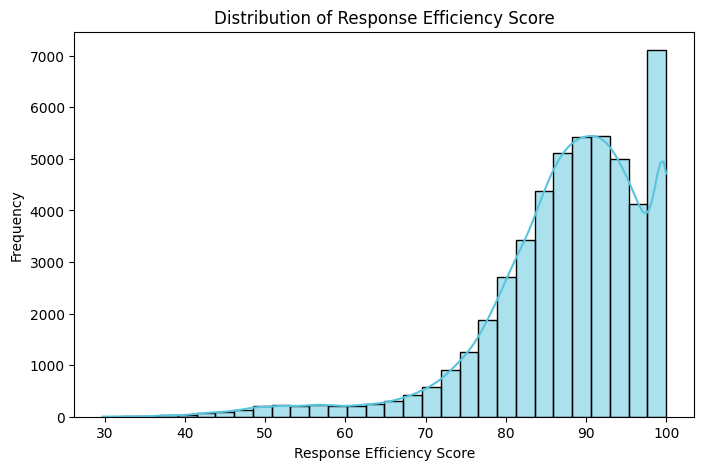

In [14]:
# 1. Distribution of Response Efficiency
plt.figure(figsize=(8,5))
sns.histplot(df['response_efficiency_score'], bins=30, kde=True, color='#58C4DD')
plt.title("Distribution of Response Efficiency Score")
plt.xlabel("Response Efficiency Score")
plt.ylabel("Frequency")
plt.show()

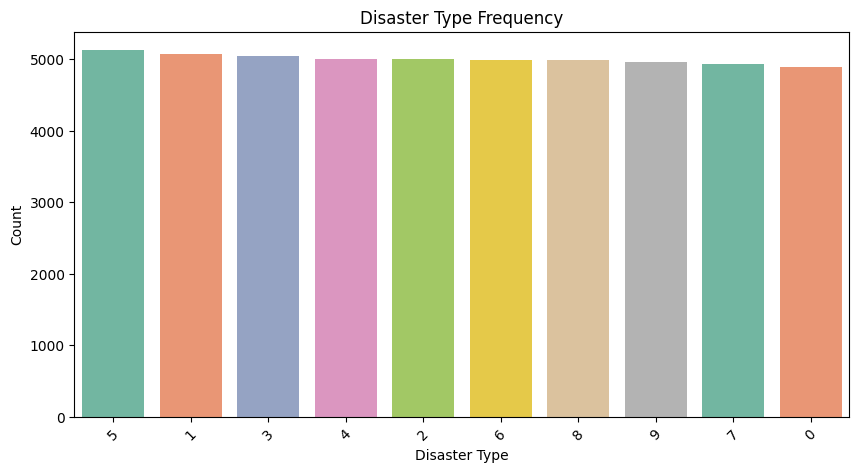

In [15]:
# 2. Disaster Type Distribution
plt.figure(figsize=(10,5))
sns.countplot(x='disaster_type', data=df, order=df['disaster_type'].value_counts().index, palette='Set2')
plt.title("Disaster Type Frequency")
plt.xticks(rotation=45)
plt.xlabel("Disaster Type")
plt.ylabel("Count")
plt.show()

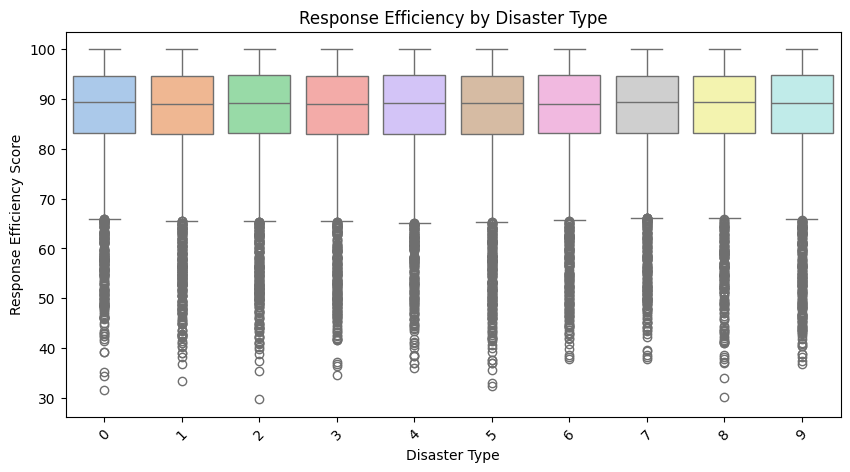

In [16]:
# 3. Response Efficiency by Disaster Type
plt.figure(figsize=(10,5))
sns.boxplot(x='disaster_type', y='response_efficiency_score', data=df, palette='pastel')
plt.title("Response Efficiency by Disaster Type")
plt.xticks(rotation=45)
plt.xlabel("Disaster Type")
plt.ylabel("Response Efficiency Score")
plt.show()

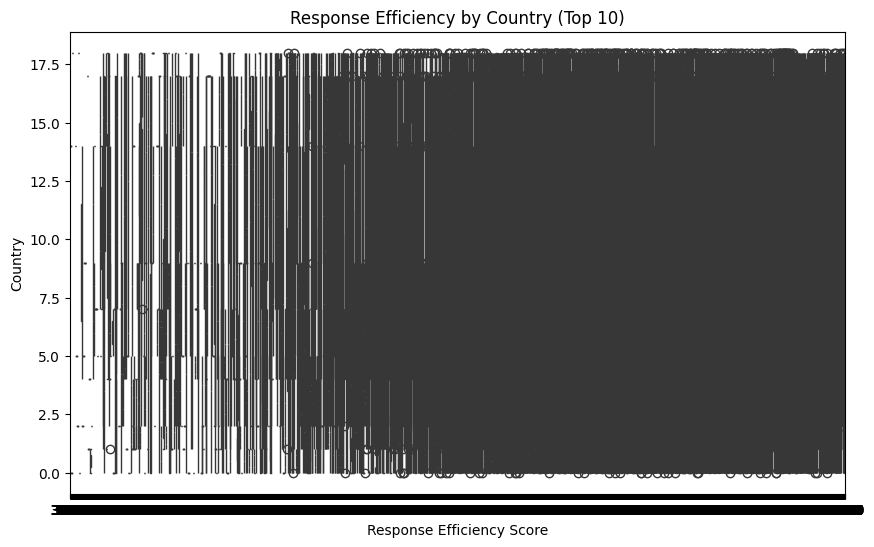

In [17]:
# 4. Response Efficiency by Country (Top 10 by frequency)
top_countries = df['country'].value_counts().nlargest(10).index
plt.figure(figsize=(10,6))
sns.boxplot(y='country', x='response_efficiency_score', data=df[df['country'].isin(top_countries)], palette='coolwarm')
plt.title("Response Efficiency by Country (Top 10)")
plt.xlabel("Response Efficiency Score")
plt.ylabel("Country")
plt.show()


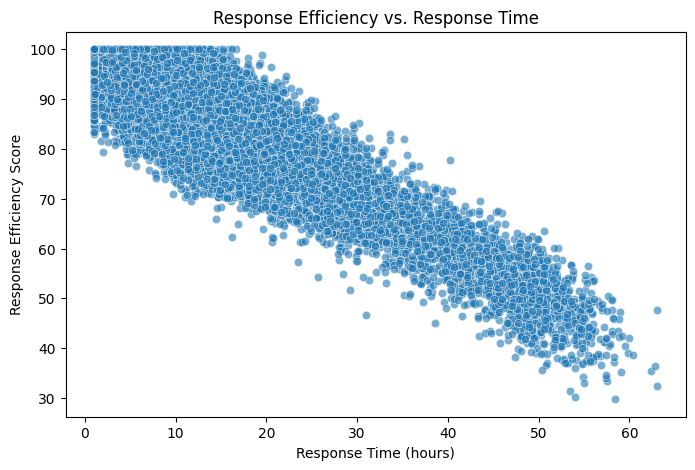

In [18]:
# 5. Relationship between Response Time and Efficiency
plt.figure(figsize=(8,5))
sns.scatterplot(x='response_time_hours', y='response_efficiency_score', data=df, alpha=0.6)
plt.title("Response Efficiency vs. Response Time")
plt.xlabel("Response Time (hours)")
plt.ylabel("Response Efficiency Score")
plt.show()


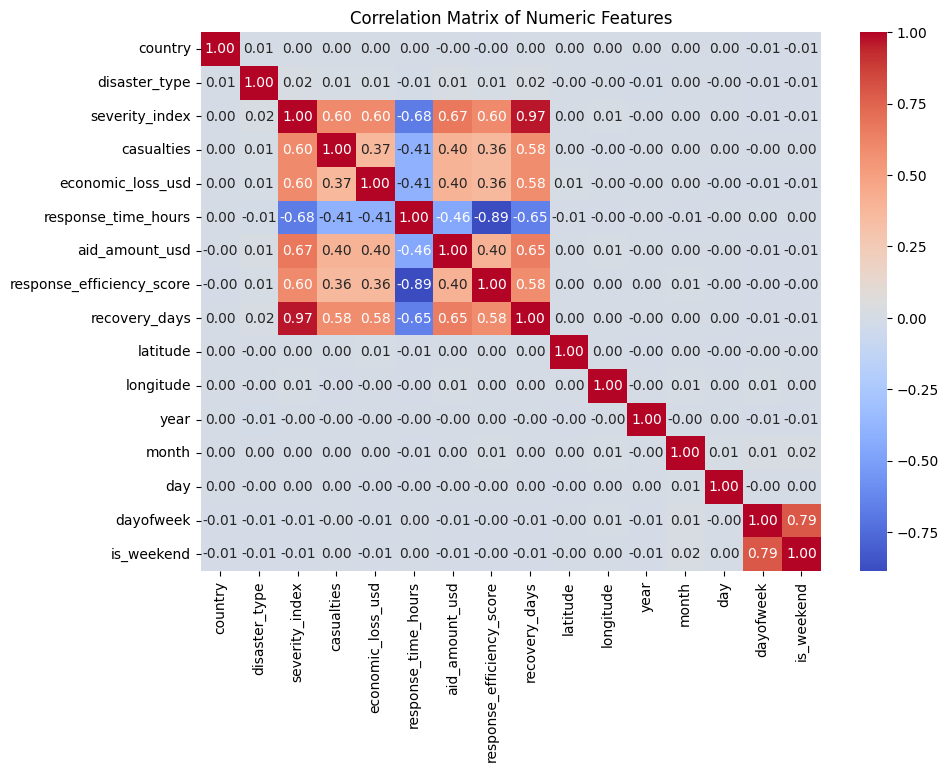

In [19]:
# 6. Correlation Heatmap
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.show()


## Train-Test Split

In [20]:
drop_cols = ['recovery_days']
df_model = df.drop(columns=drop_cols)


# Define features (X) and target (y)
X = df_model.drop(columns=['response_efficiency_score'])
y = df_model['response_efficiency_score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train Shape: {X_train.shape}")
print(f"Test Shape: {X_test.shape}")


Train Shape: (40000, 14)
Test Shape: (10000, 14)


## Model Training

This section trains two tree-based regression models:
1. **Random Forest Regressor**
2. **XGBoost Regressor**

Both models are well-suited for tabular data and handle non-linear relationships effectively.  
We evaluate them using R², Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE).

In [21]:
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# Train XGBoost
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)


##  Evaluation Function & Result


In [23]:
def evaluate_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    return {'Model': name, 'R²': r2, 'MAE': mae, 'RMSE': rmse}

results = []
results.append(evaluate_model('Random Forest', y_test, rf_preds))
results.append(evaluate_model('XGBoost', y_test, xgb_preds))

results_df = pd.DataFrame(results)
print(results_df)

           Model        R²       MAE       RMSE
0  Random Forest  0.775896  3.819442  22.497163
1        XGBoost  0.772545  3.844944  22.833510


## Results Comparison & Feature Importance
After training, it is essential to understand which features most strongly affect the predicted response efficiency.  
We will:
1. Visualize feature importance from the Random Forest model.  
2. Validate model stability through 5-fold cross-validation.  
3. Plot predicted vs. actual values to assess prediction accuracy visually.

The Random Forest feature importance plot reveals that **response_time_hours** overwhelmingly dominates the prediction of the Response Efficiency Score.  
It accounts for more than 80% of the model’s total importance, meaning that the time taken to respond to a disaster is by far the strongest determinant of response efficiency.

Other features such as `aid_amount_usd`, `economic_loss_usd`, `severity_index`, and `casualties` contribute much less to the model’s decision-making process.  
This suggests that while factors like aid and economic loss have some influence, the **speed of response** is the most critical driver of efficiency.

### Key Observations
1. **Response Time** – Strong negative influence. Faster responses consistently correspond to higher efficiency scores.  
2. **Aid Amount and Economic Loss** – Secondary contributors, potentially influencing efficiency when response times are moderate.  
3. **Severity and Casualties** – Have minor but logical effects, since more severe events may receive quicker, more organized responses.  
4. **Temporal and Geographic Features** – Minimal direct impact, indicating that efficiency depends more on operational factors than on location or timing.

The model therefore emphasizes operational speed as the main indicator of disaster management performance, aligning with real-world expectations where rapid mobilization greatly improves outcomes.

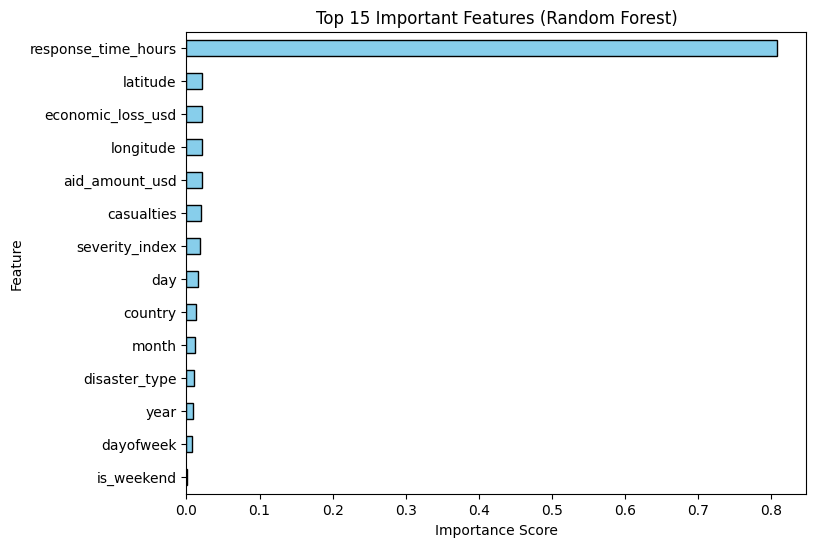

In [24]:
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(8,6))
feat_imp.tail(15).plot(kind='barh', color='skyblue', edgecolor='black')
plt.title("Top 15 Important Features (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

## Cross Val Score


The cross-validation R² shows how consistently the model performs across multiple data splits.  
A small variation among folds indicates that the model generalizes well and is not overfitting.


In [25]:
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='r2', n_jobs=-1)
mean_cv_r2 = np.mean(cv_scores)

## Cross Val Score Plot Per Fold

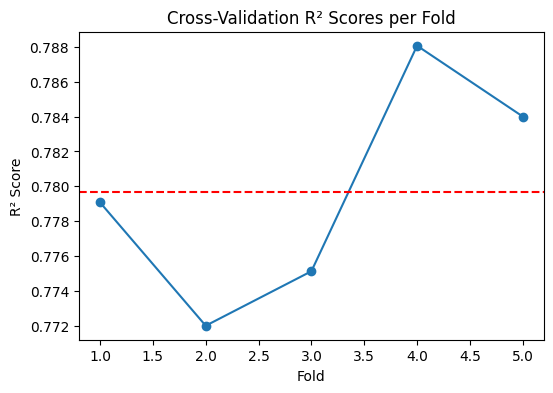

Mean Cross-validated R²: 0.779654


In [26]:
plt.figure(figsize=(6,4))
plt.plot(range(1,6), cv_scores, marker='o')
plt.axhline(y=mean_cv_r2, color='r', linestyle='--')
plt.title("Cross-Validation R² Scores per Fold")
plt.xlabel("Fold")
plt.ylabel("R² Score")
plt.show()

print(f"Mean Cross-validated R²: {mean_cv_r2:.6f}")


## Cross-Validation Results

To verify that the Random Forest model generalizes well across different subsets of the data,  
5-fold cross-validation was applied.

| Metric | Mean Score |
|---------|-------------|
| R² | **0.7797** |

The cross-validation R² scores across the folds remain closely clustered around the mean,  
showing only minor variance between 0.772 and 0.788.  
This indicates that the model performs consistently regardless of how the data is split,  
confirming that it is **not overfitting** and can be trusted to generalize to unseen disaster events.

### Key Insight
The stable mean R² of approximately 0.78 aligns well with the single-split test performance (R² ≈ 0.776),  
further validating that the model captures genuine relationships between disaster characteristics  
and response efficiency rather than memorizing specific examples.


## Predicted vs Actual (Random Forest)

### Observation

The predicted vs. actual plot shows how closely the model’s predictions align with real efficiency scores.  
Points lying near the red diagonal line indicate accurate predictions, while wider dispersion would imply residual error.

The next section will explore model interpretability using SHAP values to better understand how individual features impact predictions.


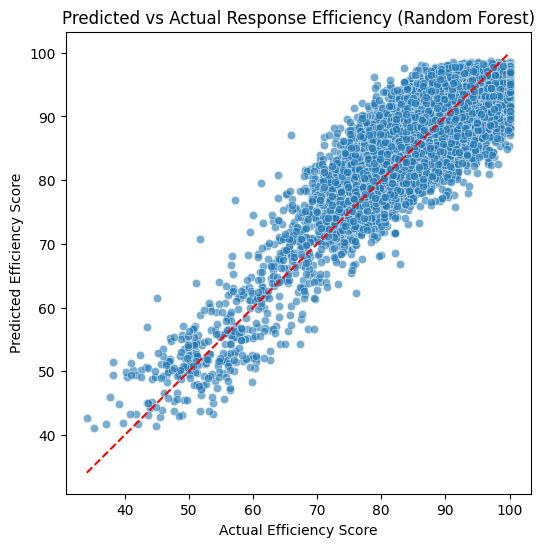

In [27]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=rf_preds, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Predicted vs Actual Response Efficiency (Random Forest)")
plt.xlabel("Actual Efficiency Score")
plt.ylabel("Predicted Efficiency Score")
plt.show()

## Conclusion

This analysis developed machine learning models to predict the **Response Efficiency Score** for global disaster events, using factors such as severity, casualties, aid amount, economic loss, and response time.

Both **Random Forest** and **XGBoost** models achieved strong predictive performance:
- Random Forest R²: **0.7759**
- XGBoost R²: **0.7725**
- Mean Cross-validated R²: **0.7797**

These results indicate that the models explain roughly 78% of the variance in response efficiency, demonstrating reliable and consistent performance across multiple folds.

### Key Insights
1. **Response Time** is the most critical factor influencing efficiency.  
   Faster responses directly correspond to higher efficiency scores.
2. **Aid Amount** and **Economic Loss** provide secondary contributions, helping improve outcomes when response times are moderate.  
3. **Severity Index** and **Casualties** show smaller but logical effects, reflecting the scale and urgency of each disaster.  
4. Temporal and geographic features contribute minimally, confirming that operational speed and resource allocation matter more than timing or location.

### Practical Implications
These findings reinforce the importance of rapid mobilization and well-coordinated aid distribution in improving disaster response outcomes.  
The model can support policymakers and emergency planners in identifying key drivers of efficiency and improving future disaster management strategies.

### Related Work
A complementary notebook based on the same dataset predicts **Recovery Days**, focusing on how quickly countries recover after disasters.  
Together, both notebooks form a comprehensive two-phase analysis:
- **Response Efficiency:** How effectively a country reacts during the immediate disaster phase.  
- **Recovery Duration:** How long it takes to achieve full post-disaster recovery.  

You can explore the related notebook here:  
👉 [Predicting Recovery Days – Global Disaster Dataset](<https://www.kaggle.com/code/seki32/predicted-recovery-days-with-randomforest-and-xgb>)

# Final Note
**If you found this notebook useful or learned something new, please consider **upvoting** to support further research on data-driven disaster management.**
